In [1]:
import cv2
import math
import qrcode
import treepoem 
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import matplotlib.backends.backend_pdf


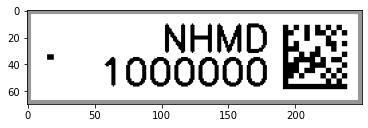

In [2]:

def make_labels(museum_no):
    label = np.ones([64,244,3]).astype('uint8')*255
    label= cv2.copyMakeBorder(label,3,3,3,3,cv2.BORDER_CONSTANT,value=[150,150,150])
    
    #make data matrix / qr code
    dm = treepoem.generate_barcode(
        barcode_type='datamatrix',  # One of the supported codes.
        data=str(museum_no), 
    ) 
    assert np.array(dm).shape == (50,50,3)
    
    back_label = deepcopy(label)
    
    label[10:60,10:60] = np.array(dm)
    back_label[-60:-10,-60:-10] = np.array(dm)
    
    cv2.putText(label, "NHMD", (70,30), 0, fontScale=0.9,color=1,thickness=2, bottomLeftOrigin=False)
    cv2.putText(back_label, "NHMD", (100,30), 0, fontScale=0.9,color=1,thickness=2, bottomLeftOrigin=False)
    cv2.putText(label, f"{museum_no}", (70,55), 0, fontScale=0.9,color=1,thickness=2, bottomLeftOrigin=False)
    cv2.putText(back_label, f"{museum_no}", (54,55), 0, fontScale=0.9,color=1,thickness=2, bottomLeftOrigin=False)
    label[33:37,230:235] = 0
    back_label[-37:-33,-235:-230] = 0

    return label, back_label



labels = make_labels(1000000)
label_width = labels[0].shape[1]
label_height = labels[0].shape[0]

plt.imshow(labels[1])

In [3]:
ROW_MARGIN = 10 #pixels
COLUMN_MARGIN = 10
LEFT_MARGIN = 100 
RIGHT_MARGIN = 100
TOP_MARGIN = 100
BOTTOM_MARGIN = 100

WIDTH = 2480
HEIGHT = 3508

start = 1000000
end = 1000010
no_labels = end - start

labels_per_row = math.floor((WIDTH - LEFT_MARGIN - RIGHT_MARGIN + ROW_MARGIN)/(labels[0].shape[1]+ROW_MARGIN))
rows_per_sheet = math.floor((HEIGHT - BOTTOM_MARGIN - TOP_MARGIN + COLUMN_MARGIN)/(labels[0].shape[0]+COLUMN_MARGIN))


break_flag = False
sheets = []
museum_no = start
for sheet_no in tqdm(range(math.ceil(no_labels/(labels_per_row*rows_per_sheet)))):
    
    #Front Side
    sheet = np.ones([HEIGHT,WIDTH,3]).astype('uint8')*255
    back_sheet = np.ones([HEIGHT,WIDTH,3]).astype('uint8')*255
    for row in tqdm(range(rows_per_sheet)):
        for col in range(labels_per_row):
            #print('row',row,'col',col)
            label, back_label = make_labels(museum_no=museum_no)
            
            pos_x = LEFT_MARGIN + (label_width+COLUMN_MARGIN)*col
            back_pos_x = WIDTH - LEFT_MARGIN - (label_width+COLUMN_MARGIN)*(col)
            pos_y = TOP_MARGIN + (label_height+ROW_MARGIN)*row
            sheet[pos_y:pos_y+label_height,pos_x:pos_x+label_width] = label
            back_sheet[pos_y:pos_y+label_height,back_pos_x-label_width:back_pos_x] = back_label
            
            museum_no+=1
            
            if museum_no > end:
                break_flag = True
                break
        if break_flag == True:
            break
            
    
    sheets += [sheet, back_sheet]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


In [4]:
from PIL import Image

pdf_path = "labels.pdf"

images = [Image.fromarray(x) for x in sheets]
images[0].save(
    pdf_path, "PDF" ,resolution=300.0, save_all=True, append_images=images[1:2]
)
            
                    

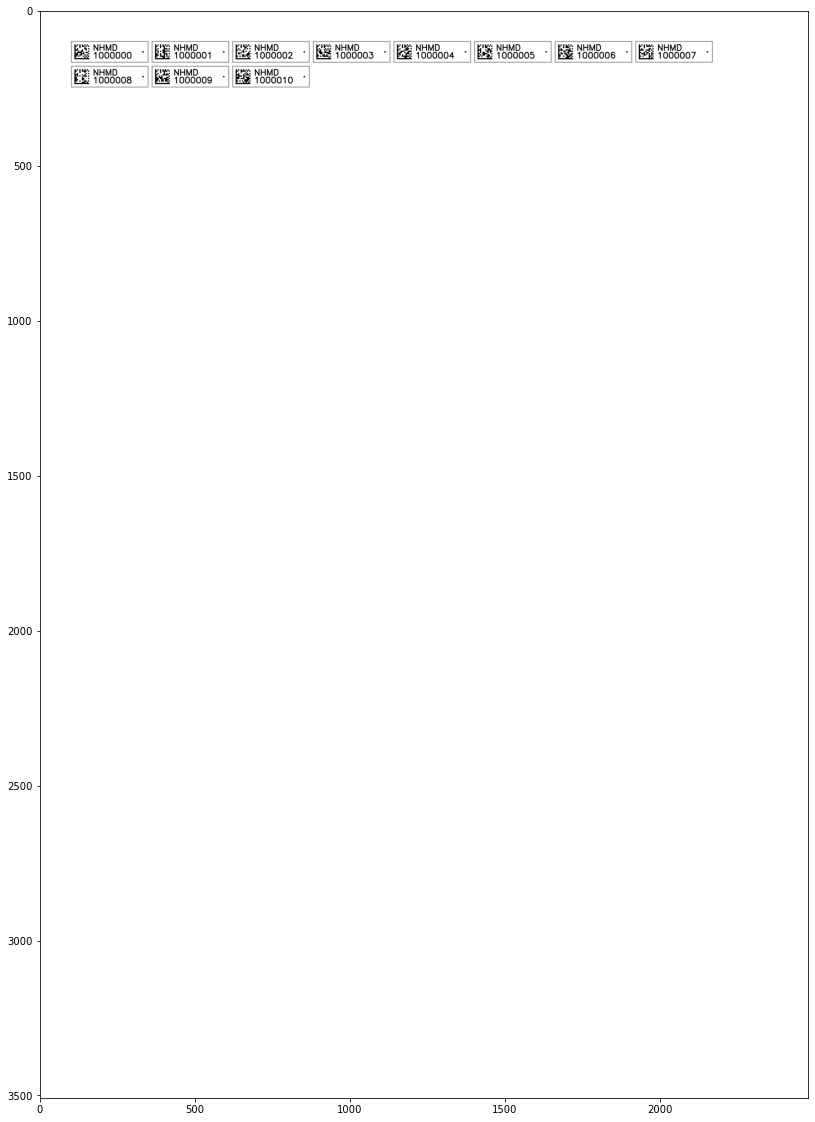

In [5]:

#plt.imsave('test_1.pdf',sheets[0],format='pdf',dpi=300)
plt.figure(figsize=(20,20))
plt.imshow(sheets[0])